# Importando bibliotecas

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import solve_ivp
import matplotlib.pyplot as pl
import scipy.io

# Importando Arquivos

In [22]:
Dados = scipy.io.loadmat('dados/dadosAntigos.mat')

Psi = scipy.io.loadmat('dados/Psi_Ba13set.mat')
# Pega a lista de itens referentes aos psi do arquivo .mat 
# no terceiro index do array Psi
Psi = list(Psi.values())[3]
Dados = list(Dados.values())[3]


# Definindo média móvel do PSI

In [23]:
npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)
Psif = np.concatenate(Psif).ravel().tolist()


# Separando dados

In [24]:
casos_dados = Dados[:,0]
recuperados_dados = Dados[:,6]
mortos_dados = Dados[:,4]
hospitalizados_dados = Dados[:,1]
uti_dados = Dados[:,2]
vacinados_dados = Dados[:,7]

data_in = '06/03/2020'

novos_casos = np.diff(casos_dados)
novos_mortos = np.diff(mortos_dados)

inicio_da_vacinacao = 100


# Definindo condicoes iniciais

In [25]:
D0          = 0;
N0          = 14930634;
R0          = 0;
H0          = 0;
U0          = 0;
V0          = 1000/N0;  
Rv0         = 0; 
Is0         = 2.015439771376298e-06;
Ia0         = 1.8028646508967777e-06;
Iav0        = 1.8028646508967777e-06; 
Isv0        = 1.8028646508967777e-06; 
E0          = 1.7639153732952095e-06;
Ev0         = 1.7639153732952095e-06;
S0          = (1-Is0-Ia0-E0);
Nw0         = 0;
NwV0        = 0;

condicoes_iniciais = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,U0,R0,Rv0,D0,Nw0,NwV0]

# Definindo modelo

In [26]:
def seiihurd(t, y):
    
    N=1
    psi=Psif[int(t)]

    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    else:
        beta=1;
    
    if t<100:
        tau=0
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        qsi_v = 0
    else:
        delta_av = 0.3090
        delta_sv = 0.3090
        phi_e = 0.8
        tau=(6.6976e-05)*1.1
        k_v=0.1
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        qsi_v = 0.53

    S=y[0]
    E=y[1]
    V=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    U=y[9]
    R=y[10]
    Rv=y[11]
    D=y[12]
    Nw=y[13]
    NwV=y[14]

    
    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau*S
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
    dVdt = tau*S - (1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*V
    dEvdt = (1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = qsi_v*gamma_sv*Isv + h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-qsi_v)*gamma_sv*Isv + phi_e*V
    dDdt = (1-ome_h)*mi_h*gamma_h*H + (1-ome_u)*mi_u*gamma_u*U
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau*S
    
    return [dSdt, dEdt,dVdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dUdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]

# Chamando modelo

In [27]:
resultados = solve_ivp(seiihurd, [0,192], condicoes_iniciais, method='RK45', t_eval=np.arange(192))
resultados_modelo = resultados.y

Sm = N0*resultados_modelo[0,:]
Em = N0*resultados_modelo[1,:]
Vm = N0*resultados_modelo[2,:]
Evm = N0*resultados_modelo[3,:]
Iam = N0*resultados_modelo[4,:]
Ism = N0*resultados_modelo[5,:]
Iavm = N0*resultados_modelo[6,:]
Isvm = N0*resultados_modelo[7,:]
Hm = N0*resultados_modelo[8,:]
Um = N0*resultados_modelo[9,:]
Rm = N0*resultados_modelo[10,:]
Rvm = N0*resultados_modelo[11,:]
Dm = N0*resultados_modelo[12,:]
Nwm = N0*resultados_modelo[13,:]
NwVm = N0*resultados_modelo[14,:]

# Plotando graficos

### Hospitalizados

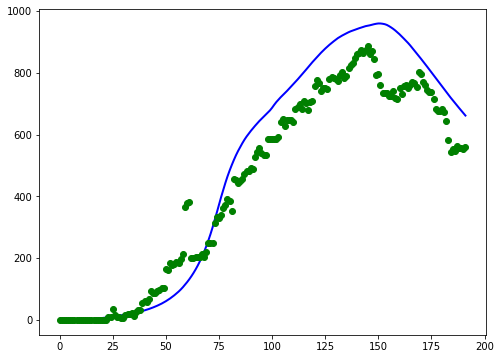

In [28]:
ts1=np.arange(192)
fig, ax = pl.subplots(figsize=(8,6))

ax.plot(ts1,  Hm, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, hospitalizados_dados[:192], color='g',zorder=1, linewidth=1)

### UTI

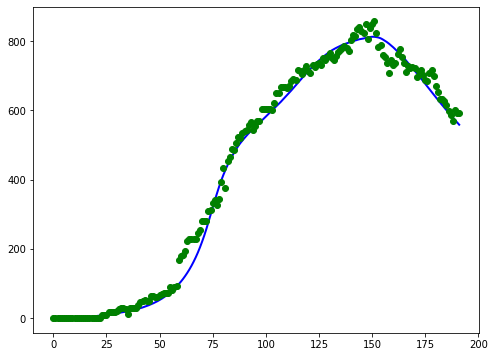

In [33]:
ts1=np.arange(192)
fig, ax = pl.subplots(figsize=(8,6))

ax.plot(ts1,  Um, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, uti_dados[:192], color='g',zorder=1, linewidth=1)

### Casos Acumulados

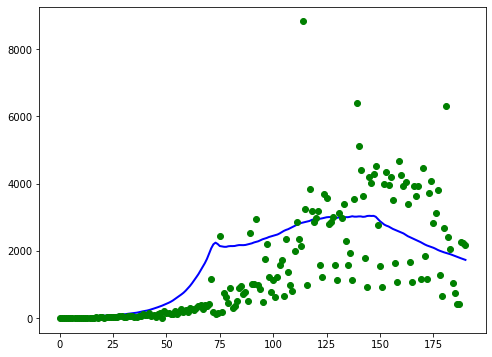

In [30]:
ts1=np.arange(191)
fig, ax = pl.subplots(figsize=(8,6))

Nwm_i = np.diff(Nwm)
Nwm_i_dados = np.diff(casos_dados)

ax.plot(ts1,  Nwm_i, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, Nwm_i_dados[:191], color='g',zorder=1, linewidth=1)

### Mortos

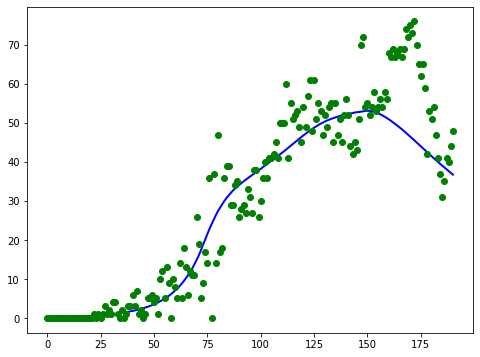

In [31]:
ts1=np.arange(191)
fig, ax = pl.subplots(figsize=(8,6))

Nwm_d = np.diff(Dm)
Nwm_d_dados = np.diff(mortos_dados)

ax.plot(ts1,  Nwm_d, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, Nwm_d_dados[:191], color='g',zorder=1, linewidth=1)

### Vacinados

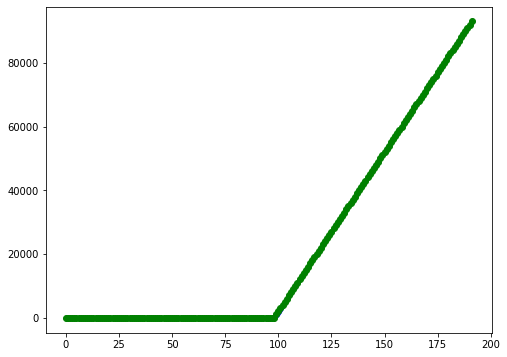

In [32]:
ts1=np.arange(192)
fig, ax = pl.subplots(figsize=(8,6))

ax.plot(ts1,  NwVm, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, vacinados_dados[:192], color='g',zorder=1, linewidth=1)